First I am going to import necessary libraries for this task

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error  # Import mean_squared_error function
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

#Styling Plots
sns.set(style="whitegrid", palette="viridis", font_scale=1.2)
plt.rcParams['figure.dpi'] = 100  # Set default figure dpi for better resolution

# 1. Data Cleaning and EDA

In [56]:
data = pd.read_csv('case_study_junior_ds.csv')

In [57]:
data.head()

,keyword_id,keyword_rank,date,searches,search_engine
0,338145,25218,2022-07-08,53000,0
1,366846,906743,2022-07-08,0,0
2,8590017696,136761,2022-07-08,7000,0
3,8590268435,60380,2022-07-08,20033,0
4,17179954797,239930,2022-07-08,2000,0


In [58]:
data.shape

(469308, 5)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469308 entries, 0 to 469307
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   keyword_id     469308 non-null  int64 
 1   keyword_rank   469308 non-null  int64 
 2   date           469308 non-null  object
 3   searches       469308 non-null  int64 
 4   search_engine  469308 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 17.9+ MB



Total Entries: 469,308
Columns: 5

keyword_id: Identifier for keywords (numerical).

keyword_rank: Rank of the keyword (numerical).

date: Date of the data record (string format, needs to be converted to date type for any time series analysis).

searches: Number of searches for the keyword (numerical).

search_engine: Numerical identifier for the search engine (numerical).


In [60]:
# Check for missing data in the dataset
missing_data = data.isnull().sum()
missing_data

keyword_id       0
keyword_rank     0
date             0
searches         0
search_engine    0
dtype: int64

In [61]:
# Check for duplicate rows in the dataset
duplicate_data = data.duplicated().sum()
duplicate_data

0

In [63]:
# Converting date from a string to a datetime format
data['date'] = pd.to_datetime(data['date'])

In [64]:
data.describe()

,keyword_id,keyword_rank,date,searches,search_engine
count,4.693080e+05,4.693080e+05,469308,4.693080e+05,469308.000000
mean,1.955014e+12,7.439009e+05,2022-07-10 23:33:51.276687360,8.550373e+03,6.818188
min,5.850000e+03,3.000000e+00,2022-07-08 00:00:00,0.000000e+00,0.000000
25%,7.988642e+11,7.421850e+04,2022-07-09 00:00:00,0.000000e+00,3.000000
50%,1.838246e+12,2.360955e+05,2022-07-11 00:00:00,0.000000e+00,5.000000
75%,3.049427e+12,7.821010e+05,2022-07-13 00:00:00,3.000000e+03,10.000000
max,4.389457e+12,1.391182e+07,2022-07-14 00:00:00,1.863716e+07,25.000000
std,1.290018e+12,1.388063e+06,NaN,8.279563e+04,5.185202


# 2. Answering the question
According to this data, how many searches does the keyword with rank 1 receive for each search engine?


In [65]:
# Check if there are any entries with 'keyword_rank' = 1
rank_1_data = data[data['keyword_rank'] == 1]

# If no rank 1 data is available, notify and prepare to adjust analysis strategy
if rank_1_data.empty:
    print("We dont have rank 1. We need to find minimum available ranks.")

We dont have rank 1. We need to find minimum available ranks.


In [66]:
# Filter data for the lowest rank present in the dataset
lowest_rank = data['keyword_rank'].min()
top_keyword_data = data[data['keyword_rank'] == lowest_rank]
top_keyword_data

,keyword_id,keyword_rank,date,searches,search_engine
292355,1606317975332,3,2022-07-09,1334983,8
303484,1606317975332,3,2022-07-14,1213935,8
399058,1554778255514,3,2022-07-08,2320465,13
402936,1554778255514,3,2022-07-10,8312244,13
404919,1554778255514,3,2022-07-11,10424650,13
406894,1554778255514,3,2022-07-12,2172276,13
408801,1554778255514,3,2022-07-13,1965862,13
410678,1554778255514,3,2022-07-14,2020650,13


In [67]:
# Analyze the number of searches for this keyword across different search engines
search_counts = top_keyword_data.groupby(['keyword_id', 'search_engine'])['searches'].sum().unstack(fill_value=0)

# Display the findings
print("Search counts for the lowest ranked keyword across different search engines:")
print(search_counts)

Search counts for the lowest ranked keyword across different search engines:
search_engine       8         13
keyword_id                      
1554778255514        0  27216147
1606317975332  2548918         0


### Search Counts for the Lowest Ranked Keyword Across Different Search Engines

The lowest rank in our dataset is keyword_rank = 3. 

For this rank, the search engines responsible for this rank are 13 and 8.


#### Search Summary by Keyword ID and Search Engine:

| keyword_id    | Search Engine 8 | Search Engine 13 |
|---------------|-----------------|------------------|
| 1554778255514 | 0               | 27,216,147       |
| 1606317975332 | 2,548,918       | 0                |

### Explanation:

This table shows the total number of searches for each of the lowest ranked keywords (rank = 3) across two search engines. The `keyword_id` column represents unique identifiers for the keywords, while the other columns represent different search engines (8 and 13). 


In [68]:
# Calculate the total searches per search engine
total_searches_per_engine = search_counts.sum()
print("Total Searches per Search Engine:\n", total_searches_per_engine)

Total Searches per Search Engine:
 search_engine
8      2548918
13    27216147
dtype: int64


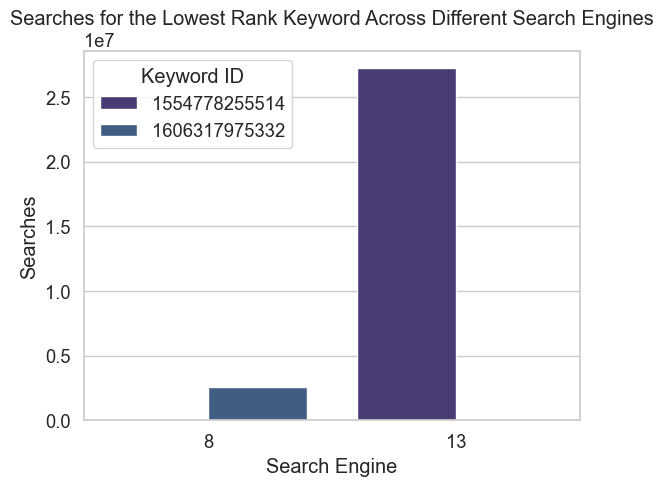

In [69]:
# Assuming 'search_counts' contains the sum of searches for the lowest rank keywords per search engine
# First, convert 'search_counts' from wide format to long format
search_counts_melted = search_counts.reset_index().melt(id_vars='keyword_id', var_name='search_engine', value_name='searches')

# Now, use this melted DataFrame with seaborn to create the bar plot
sns.barplot(x='search_engine', y='searches', hue='keyword_id', data=search_counts_melted)
plt.title('Searches for the Lowest Rank Keyword Across Different Search Engines')
plt.xlabel('Search Engine')
plt.ylabel('Searches')
plt.legend(title='Keyword ID')
plt.show()



# 3. Data Visualization

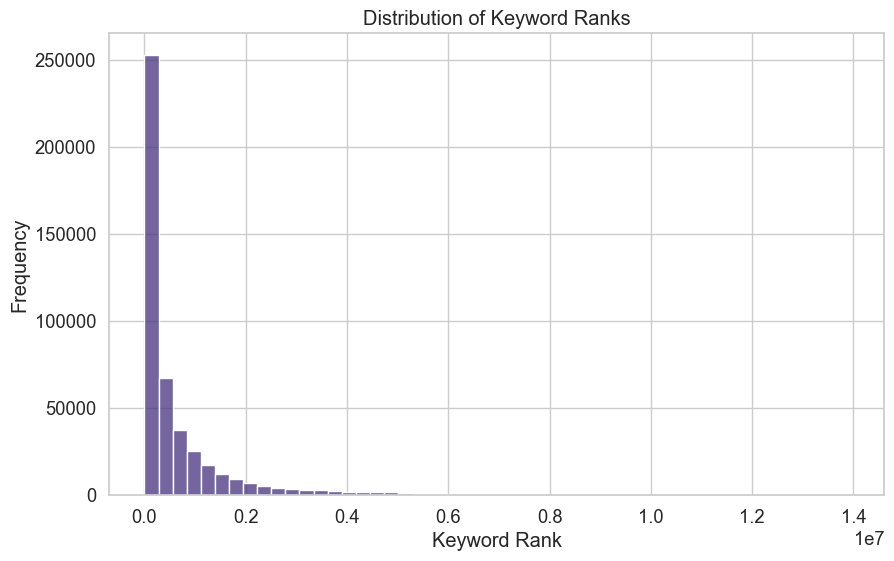

In [70]:
# Distribution of keyword ranks
plt.figure(figsize=(10, 6))
sns.histplot(data['keyword_rank'], bins=50, kde=False)
plt.title('Distribution of Keyword Ranks')
plt.xlabel('Keyword Rank')
plt.ylabel('Frequency')
plt.show()

High Frequency at Lower Ranks: There's a significant frequency of keywords with lower ranks (towards the left side of the histogram). This indicates a concentration of keywords that are ranked closer to the top when searches are performed, which typically means these keywords are more popular or relevant.

Long Tail Distribution: The distribution has a long tail extending towards the higher ranks (towards the right side of the histogram), suggesting that there are many keywords with very high rank values but they occur less frequently. These keywords are likely less popular or relevant in searches.

Skewed Distribution: The data is right-skewed, meaning most of the data is concentrated in the lower range of keyword ranks. The tail of the distribution stretching to the right shows that while most keywords rank well, there are still a significant number of keywords that rank poorly.


Text(0, 0.5, 'Total Searches')

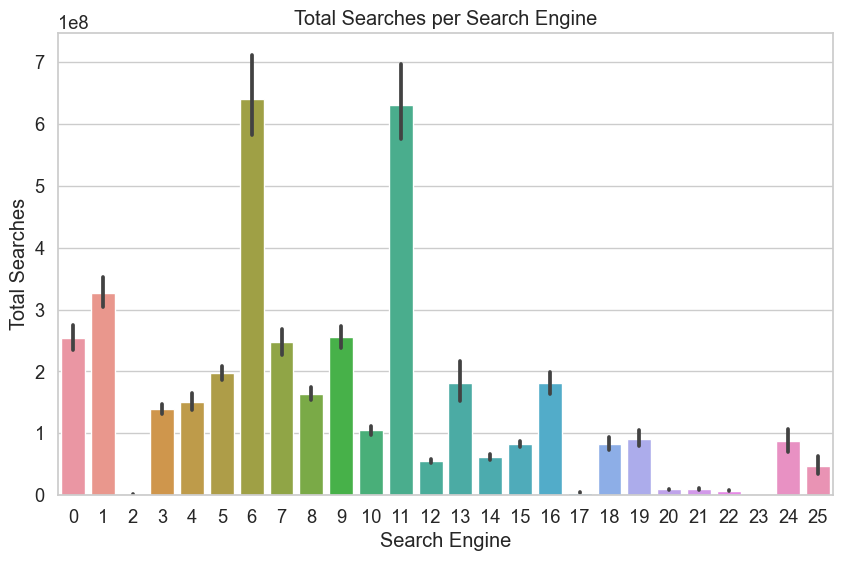

In [71]:
# Number of searches per search engine
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='search_engine', y='searches', data=data, estimator=np.sum)
plt.title('Total Searches per Search Engine')
plt.xlabel('Search Engine')
plt.ylabel('Total Searches')

Variability in Search Volume: There is noticeable variability in the total searches per search engine. Some search engines have significantly higher search volumes compared to others, indicating differences in popularity or usage frequency among them.

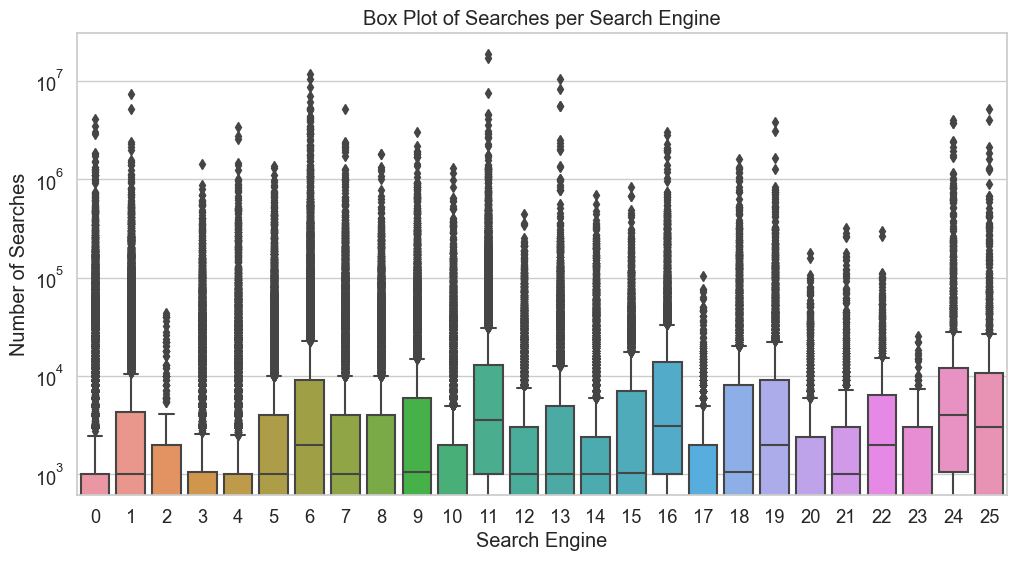

In [72]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='search_engine', y='searches', data=data)
plt.title('Box Plot of Searches per Search Engine')
plt.xlabel('Search Engine')
plt.ylabel('Number of Searches')
plt.yscale('log')  # Use logarithmic scale if range is large
plt.show()

Outliers: The plot clearly shows outliers as individual points above the whiskers. These are search counts that are unusually high compared to the typical range of searches for that search engine.

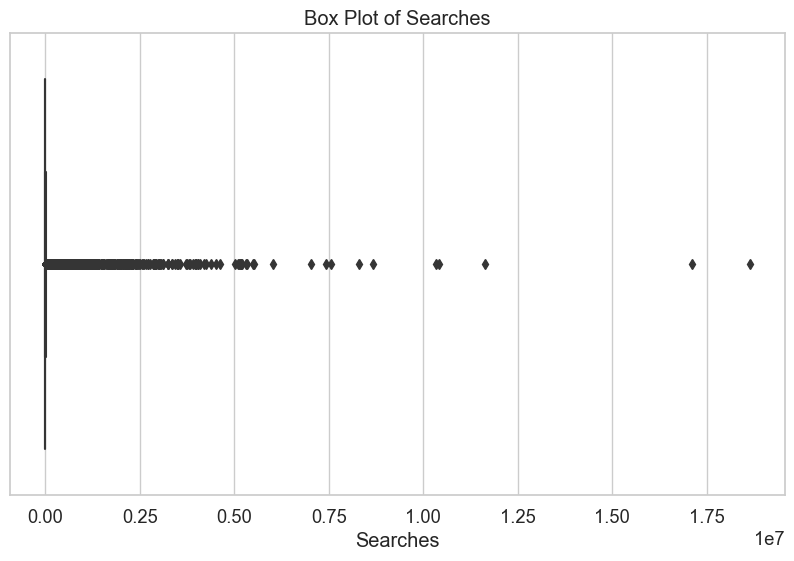

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['searches'])
plt.title('Box Plot of Searches')
plt.xlabel('Searches')
plt.show()

This box plot highlights the presence of highly skewed data with many outliers, suggesting that a few keywords drive a disproportionately large number of searches. 

# 4. Modeling

Interpretation of Variables: If search_engine is just a label for different search engines (e.g., Google, Bing, etc.), treating it as numerical would imply a non-existent ordinal relationship (i.e., that a search engine with a higher number might somehow perform "better" or is "more" of a search engine than one with a lower number). This could lead to misleading or incorrect model interpretations and predictions.

Converting the 'search_engine' column to a categorical type, then apply one-hot encoding to this column. This will create new columns in the DataFrame, each representing a category of the original 'search_engine' column, with binary values indicating the presence of each category.

In [73]:
#The 'search_engine' column is converted to a category
data['search_engine'] = data['search_engine'].astype('category')

In [75]:
# Convert 'search_engine' to categorical
data['search_engine'] = data['search_engine'].astype('category')

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Perform one-hot encoding
encoded_search_engine = encoder.fit_transform(data[['search_engine']])

# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_search_engine, columns=encoder.get_feature_names_out(['search_engine']))

# Concatenate the new dataframe with the original data
data_encoded = pd.concat([data, encoded_df], axis=1)

# Display the updated dataframe
data_encoded.head()

,keyword_id,keyword_rank,date,searches,search_engine,search_engine_0,search_engine_1,search_engine_2,search_engine_3,search_engine_4,...,search_engine_16,search_engine_17,search_engine_18,search_engine_19,search_engine_20,search_engine_21,search_engine_22,search_engine_23,search_engine_24,search_engine_25
0,338145,25218,2022-07-08,53000,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,366846,906743,2022-07-08,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8590017696,136761,2022-07-08,7000,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8590268435,60380,2022-07-08,20033,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17179954797,239930,2022-07-08,2000,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Converting the 'date' column to a datetime type and extract the year, month, and day as separate features.

In [76]:
# Convert 'date' to datetime
data_encoded['date'] = pd.to_datetime(data_encoded['date'])

# Extract year, month, and day as separate features
data_encoded['year'] = data_encoded['date'].dt.year
data_encoded['month'] = data_encoded['date'].dt.month
data_encoded['day'] = data_encoded['date'].dt.day

# Display the updated DataFrame
data_encoded[['date', 'year', 'month', 'day']].head()

,date,year,month,day
0,2022-07-08,2022,7,8
1,2022-07-08,2022,7,8
2,2022-07-08,2022,7,8
3,2022-07-08,2022,7,8
4,2022-07-08,2022,7,8


Preparing the data for modeling by dropping redundant columns and defining the target variable. Then Spliting the data into training and testing sets.

In [77]:
# Drop the original 'date' and 'search_engine' columns as they are now redundant
data_model = data_encoded.drop(['date', 'search_engine', 'keyword_id'], axis=1)

# Define the target variable and features
X = data_model.drop('searches', axis=1)
y = data_model['searches']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training a Linear Regression model on the training data and evaluate it using the Mean Squared Error (MSE) on the test data.

In [78]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

For a detailed statistical summary, Using the OLS (Ordinary Least Squares) method from statsmodels.

In [79]:
# Predict on the test data
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4712606855.940811


In [80]:
# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

# Fit the model using OLS
model_sm = sm.OLS(y_train, X_train_const).fit()

# Get the summary
model_summary = model_sm.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     131.2
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:31:00   Log-Likelihood:            -4.7964e+06
No. Observations:              375446   AIC:                         9.593e+06
Df Residuals:                  375418   BIC:                         9.593e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
keyword_rank        -0.0028      0.000  

# 5. Evaluation

### Mean Squared Error (MSE)
The Mean Squared Error for your linear regression model is approximately 4,712,606,855.94. This is quite high, indicating that the model's predictions deviate significantly from the actual values. This could suggest the model is not fitting the data well or that the data itself is highly variable.

### OLS Regression Results
- **R-squared value is 0.009**: This is very low, showing that only 0.9% of the variance in the 'searches' variable is explained by the model. This implies the model does not explain much of the variability in the target variable.
- **F-statistic and its associated p-value**: The model is statistically significant overall (p < 0.05), indicating that at least some of the predictors are useful in explaining the variation in 'searches'.

#### Coefficients:
- **Search Engine Categories**: The coefficients vary significantly across different search engines, indicating varying impacts on 'searches'. For example, `search_engine_6` and `search_engine_24` show large positive coefficients, suggesting a strong positive impact on 'searches' when these categories are present. Conversely, `search_engine_17` and `search_engine_20` have large negative coefficients, indicating a strong negative impact on 'searches'.
- **Temporal features (year, month, day)**: The 'year' has a positive coefficient, suggesting an increase in searches over the years. The 'month' has a very small positive coefficient, indicating a slight increase in searches across months. However, 'day' has a substantial negative coefficient, suggesting a decrease in searches as the days of the month increase.

### Model diagnostics:
- **Durbin-Watson statistic**: Approximately 2.00, indicating no autocorrelation in the residuals.
- **Multicollinearity**: The warning about a small eigenvalue suggests potential multicollinearity, meaning some predictors might be highly correlated with each other. This can make the model estimates unreliable.
- **Normality**: The Omnibus test indicates the residuals are not normally distributed, which can affect the reliability of some statistical tests.




#### Adjusting model

Mean Squared Error: 2409534.146390386
                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1891.
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:31:10   Log-Likelihood:            -2.8080e+06
No. Observations:              320481   AIC:                         5.616e+06
Df Residuals:                  320453   BIC:                         5.616e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
co

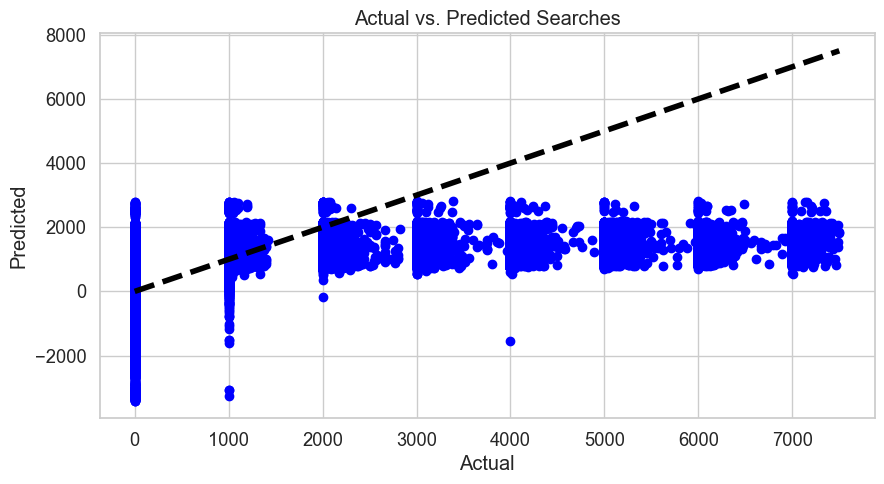

In [81]:
#Adjusting model
# Remove 'date', 'day', 'month', and 'year' from the dataset
data_encoded.drop(['date', 'day', 'month', 'year'], axis=1, inplace=True)

# Removing outliers
Q1 = data_encoded['searches'].quantile(0.25)
Q3 = data_encoded['searches'].quantile(0.75)
IQR = Q3 - Q1
data_clean = data_encoded[~((data_encoded['searches'] < (Q1 - 1.5 * IQR)) | (data_encoded['searches'] > (Q3 + 1.5 * IQR)))]

# Prepare the features and target variable
X = data_clean.drop(['searches'], axis=1)
y = data_clean['searches']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training: Use Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adding a constant to the model (necessary for statsmodels)
X_train_sm = sm.add_constant(X_train)  # Adding a constant for the intercept
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(model_sm.summary())

# Plotting the results: Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Searches')
plt.show()


### Model Performance
- **Dependent Variable**: `searches`
- **R-squared**: 0.137
  - This indicates that the model explains about 13.7% of the variance in the number of searches, which is relatively low. It suggests that the model, although statistically significant, captures only a small portion of the factors that influence search volumes.
- **Adjusted R-squared**: 0.137
  - Similar to the R-squared, this value confirms that the independent variables do not provide a strong predictive value for the dependent variable after adjusting for the number of predictors.

### Model Fit
- **F-statistic**: 1891
  - The model is statistically significant as indicated by the F-statistic. This suggests that the model provides a better fit than an intercept-only model.
- **Prob (F-statistic)**: 0.00
  - This near-zero p-value indicates that the model fit is statistically significant, meaning that there is a very low probability that the observed results are due to chance.

### Coefficients
- The coefficients table shows the estimated impact of each predictor variable on the number of searches. For instance:
  - `search_engine_0`: Coefficient of 542.1016 suggests that being in this category of search engine is associated with an increase of approximately 542 searches, holding all other variables constant.
- **Significance of Predictors**: Most predictors are significant with p-values less than 0.05, indicating strong evidence against the null hypothesis for these coefficients.

# 5. Conclusion

Given the moderate R-squared and high multicollinearity, while the model is statistically significant, its practical relevance might be limited due to the low explanatory power and potential overfitting or biases introduced by multicollinearity. The model's predictions should be interpreted with caution, and further refinement or use of different modeling approaches is recommended.

---


I can work on the residuals of model in this way for extra evaluation

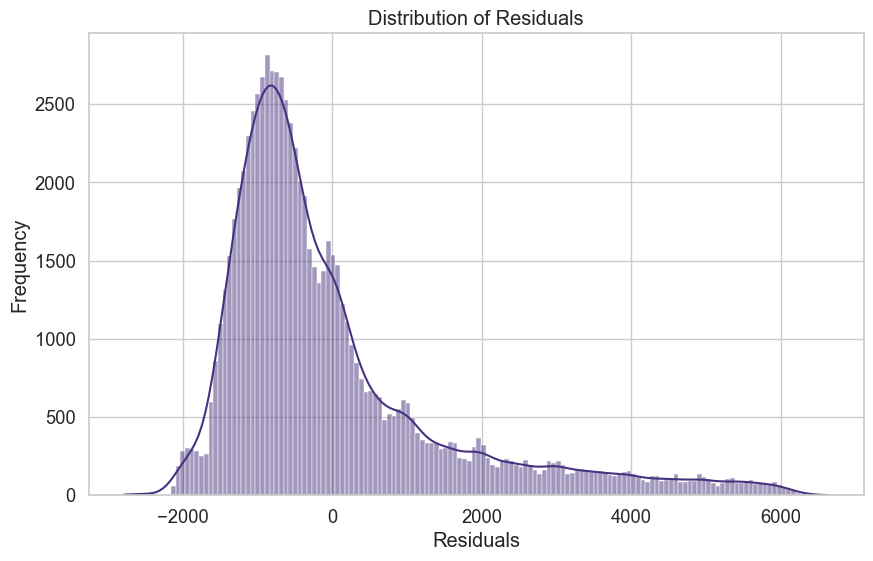

In [42]:
# Predict values using the test set
predicted = model.predict(X_test)

# Calculate residuals
residuals = y_test - predicted

#Distribution of residuals 
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

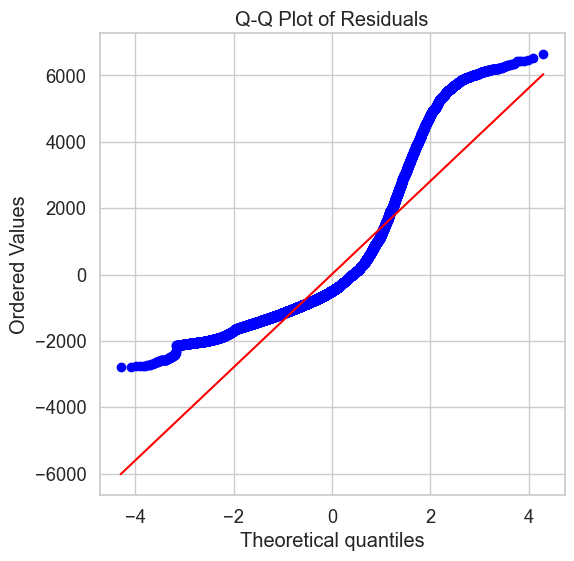

In [45]:
#Checking Normality
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

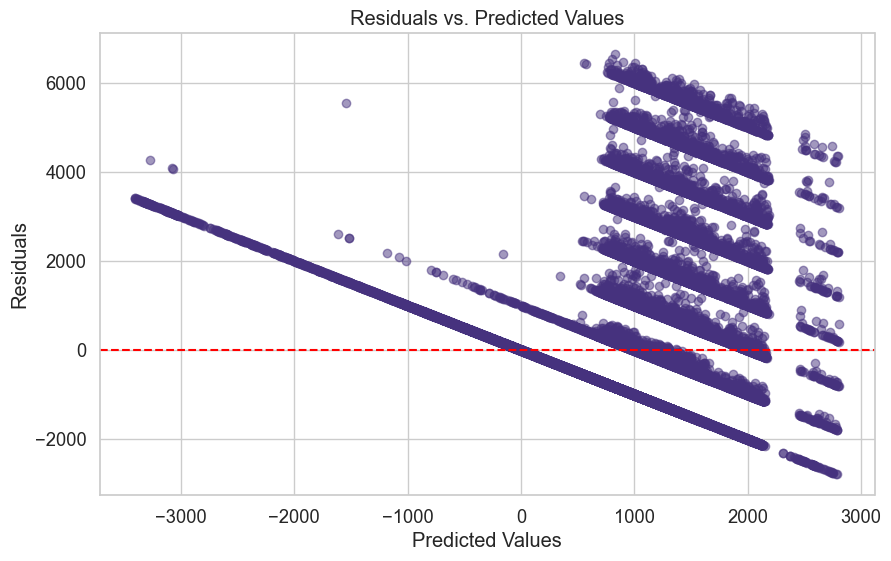

In [47]:
#checking Homoscedasticity
plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()
